In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

from scipy import interp

import tensorflow as tf

In [2]:
#set random seed
rs=6
tf.random.set_seed(rs)
np.random.seed(rs)

In [3]:
#Load data
data=pd.read_csv('part2_data.csv')

In [4]:
#Remove column 
data=data.drop(columns='claim_amount')

In [5]:
#Split features from labels
X, Y = data.loc[:, data.columns!= 'made_claim'].values, data.loc[:, data.columns == 'made_claim'].values.ravel()

In [6]:
#Split to train, validation, test
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.1, random_state=rs)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, random_state=rs)

In [7]:
#Scale data
ss=StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)

In [8]:
#We have imbalanced data so need to adjust loss for that
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
# val_class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_val), Y_val)

In [9]:
#Initializes weights in neural network 
NormalInitializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.25, seed=rs)
#Optimizer
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
#Add layers with parameters of your choice
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(7, activation='relu', kernel_initializer=NormalInitializer, bias_initializer='zeros'))
# model.add(tf.keras.layers.Dense(7, activation='relu', kernel_initializer=NormalInitializer, bias_initializer='zeros'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=NormalInitializer, bias_initializer='zeros'))
#Compile model. Rerunning this cell resets weights to initial state.
model.compile(optimizer=sgd, loss='binary_crossentropy')

Train on 16200 samples, validate on 1800 samples
Epoch 1/30
16200/16200 [==============================] - 1s 59us/sample - loss: 0.4341 - val_loss: 0.3226
Epoch 2/30
16200/16200 [==============================] - 0s 27us/sample - loss: 0.3129 - val_loss: 0.2968
Epoch 3/30
16200/16200 [==============================] - 0s 27us/sample - loss: 0.3029 - val_loss: 0.2926
Epoch 4/30
16200/16200 [==============================] - 0s 27us/sample - loss: 0.3010 - val_loss: 0.2913
Epoch 5/30
16200/16200 [==============================] - 0s 27us/sample - loss: 0.3002 - val_loss: 0.2906
Epoch 6/30
16200/16200 [==============================] - 0s 27us/sample - loss: 0.2997 - val_loss: 0.2903
Epoch 7/30
16200/16200 [==============================] - 0s 27us/sample - loss: 0.2994 - val_loss: 0.2900
Epoch 8/30
16200/16200 [==============================] - 0s 27us/sample - loss: 0.2991 - val_loss: 0.2898
Epoch 9/30
16200/16200 [==============================] - 0s 27us/sample - loss: 0.2988 - val_l

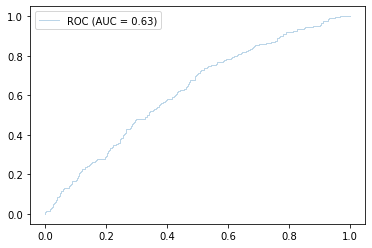

In [10]:
#Enforces early stop if val_loss behaves in a certain way
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.005, patience = 5, mode='auto', restore_best_weights=True)
#Fit model. Progress is not lost when you rerun this cell, e.g. if you run it manually twice it's like you did 2*num_epochs of training.
model.fit(X_train_scaled, Y_train, class_weight=class_weights, epochs=30, validation_data=(X_val_scaled, Y_val), callbacks=[EarlyStopping])
model.summary()

#Plot ROC
fpr, tpr, thresholds = roc_curve(Y_test, model.predict(X_test_scaled))
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC (AUC = %0.2f)' % auc(fpr, tpr))
plt.legend(loc='best')
plt.show()

In [11]:
#Save good models (with AUC>0.65)

# model.save('model_keras_xxx.h5')